<a href="https://colab.research.google.com/github/Urvashi7777/verifier/blob/main/Verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Recreate the model architecture

In [ ]:
!pip install opencv-python

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Recreate the model architecture
input_shape = (128, 128, 1)
inputs = Input(input_shape)
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
flatten = Flatten()(maxp_4)
dense_1 = Dense(256, activation='relu')(flatten)
dropout_1 = Dropout(0.4)(dense_1)
dense_2 = Dense(256, activation='relu')(flatten)
dropout_2 = Dropout(0.4)(dense_2)
output_1 = Dense(1, activation='sigmoid', name='legality_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# Compile the model (same as the original)
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

# Load the weights into the model
model.load_weights('model.weights.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Capture and Process Live Webcam Image for Age Prediction

In [ ]:
import base64
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import numpy as np
import cv2


def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to half of the video size to save bandwidth
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks()[0].stop();
        const imageData = canvas.toDataURL('image/jpeg', quality);
        div.remove();
        return imageData;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = np.frombuffer(base64.b64decode(data.split(',')[1]), dtype=np.uint8)
    img = cv2.imdecode(binary, cv2.IMREAD_COLOR)
    cv2.imwrite(filename, img)
    return filename

# Capture a photo
image_path = take_photo()


<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


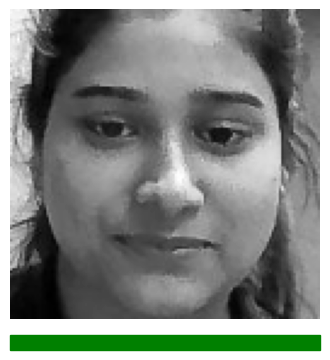

Predicted Legality: Illegal
Predicted Age: 35


In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array

# Define the legality dictionary
legality_dict = {0: 'Illegal', 1: 'Legal'}  # Example dictionary, adjust according to your labels

# Load the image
img_color = cv2.imread(image_path)

# Convert the image to grayscale for face detection
gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Check if at least one face was found
if len(faces) > 0:
    # Assume the first detected face is the one we want to focus on
    (x, y, w, h) = faces[0]

    # Crop the image to the face
    face = img_color[y:y+h, x:x+w]

    # Resize the face to the required size
    face = cv2.resize(face, (128, 128))

    # Convert the face image to grayscale (as expected by the model)
    face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

    # Preprocess the face image
    img = img_to_array(face_gray)
    img = img / 255.0
    img = img.reshape(1, 128, 128, 1)

    # Predict both legality and age
    predictions = model.predict(img)
    pred_legality = legality_dict[round(predictions[0][0][0])]
    pred_age = round(predictions[1][0][0])

    # Determine the color based on the age
    if pred_age > 25:
        color = 'green'
    elif pred_age < 19:
        color = 'red'
    else:
        color = 'orange'

    # Display the cropped face image with a scale indicator
    fig, ax = plt.subplots(figsize=(4, 5))  # Adjusted figure size for better proportions
    ax.imshow(face_gray, cmap='gray')
    ax.axis('off')

    # Create a scale (horizontal bar) below the image
    scale_width = 0.05  # Adjusted width of the scale
    rect = plt.Rectangle((0, -0.1), 1, scale_width, color=color, transform=ax.transAxes, clip_on=False)
    ax.add_patch(rect)

    # Display the figure
    plt.show()

    # Print predictions
    print(f"Predicted Legality: {pred_legality}")
    print(f"Predicted Age: {pred_age}")
else:
    print("No face detected in the image.")


## Face Detection and Age Prediction from Uploaded Image

Saving boy_7.jpg to boy_7.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


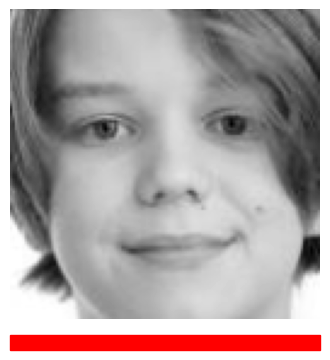

Predicted Legality: Illegal
Predicted Age: 5


In [ ]:
import cv2
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
import numpy as np
from google.colab import files
from PIL import Image as PILImage
import io

# Define the legality dictionary
legality_dict = {0: 'Illegal', 1: 'Legal'}  # Example dictionary, adjust according to your labels

# Function to predict age and legality based on uploaded image
def predict_age_and_legality(image_data, model):
    # Convert image data to PIL Image
    img = PILImage.open(io.BytesIO(image_data))

    # Convert to OpenCV format
    img_color = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    # Convert the image to grayscale for face detection
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

    # Load the Haar Cascade for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if at least one face was found
    if len(faces) > 0:
        # Assume the first detected face is the one we want to focus on
        (x, y, w, h) = faces[0]

        # Crop the image to the face
        face = img_color[y:y+h, x:x+w]

        # Resize the face to the required size
        face = cv2.resize(face, (128, 128))

        # Convert the face image to grayscale (as expected by the model)
        face_gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

        # Preprocess the face image
        img_array = img_to_array(face_gray)
        img_array = img_array / 255.0
        img_array = img_array.reshape(1, 128, 128, 1)

        # Predict both legality and age
        predictions = model.predict(img_array)
        pred_legality = legality_dict[round(predictions[0][0][0])]
        pred_age = round(predictions[1][0][0])

        # Determine the color based on the age
        if pred_age > 25:
            color = 'green'
        elif pred_age < 19:
            color = 'red'
        else:
            color = 'orange'

        # Display the cropped face image with a scale indicator
        fig, ax = plt.subplots(figsize=(4, 5))  # Adjusted figure size for better proportions
        ax.imshow(face_gray, cmap='gray')
        ax.axis('off')

        # Create a scale (horizontal bar) below the image
        scale_width = 0.05  # Adjusted width of the scale
        rect = plt.Rectangle((0, -0.1), 1, scale_width, color=color, transform=ax.transAxes, clip_on=False)
        ax.add_patch(rect)

        # Display the figure
        plt.show()

        # Print predictions
        print(f"Predicted Legality: {pred_legality}")
        print(f"Predicted Age: {pred_age}")
    else:
        print("No face detected in the image.")

# Upload an image
uploaded = files.upload()

# Assuming only one file is uploaded
image_path = next(iter(uploaded))

# Get image data from uploaded file
image_data = uploaded[image_path]

# Call the function with the uploaded image data
predict_age_and_legality(image_data, model)
